In [223]:
%cd /om/user/xboix/src/adversarial/Robustness

/om/user/xboix/src/adversarial/Robustness


In [224]:
results_dir = '/vast/robustness/'

In [225]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.set_context("poster")

import matplotlib.pyplot as plt
import pandas as pd
import pickle 

import numpy as np

import runs.config_experiments as run
experiment_list = run.config_experiments(results_dir, create_json=False)

70 config files created


In [226]:
name_attacks = ["linfpgd", "l2fgsm"]

In [227]:
# Hash table of parameters
parameters = {"epsilon": {}, "backbone": {}, "initial_learning_rate": {}, "robust_training": {}}
for exp in experiment_list:
    for kk in parameters.keys():
        if exp[kk] in parameters[kk]:
            parameters[kk][exp[kk]].append(int(exp["model_name"]))
        else:
            parameters[kk][exp[kk]] = [int(exp["model_name"])]

        if exp[kk] in parameters[kk]:
            parameters[kk][exp[kk]].append(int(exp["model_name"]))
        else:
            parameters[kk][exp[kk]] = [int(exp["model_name"])]

for kk in parameters.keys():
    print(kk)
    print(list(parameters[kk].keys()))

epsilon
[0.01, 0.05, 0.1, 0.25, 0.5, 1]
backbone
['MLP', 'CNN']
initial_learning_rate
[0.1, 0.01, 0.001, 0.0001, 1e-05]
robust_training
[True, False]


[64, 60, 61, 62, 63]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


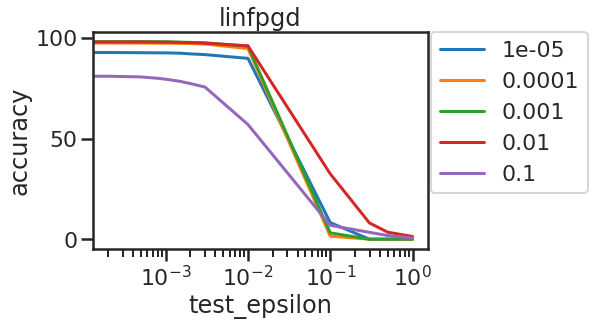

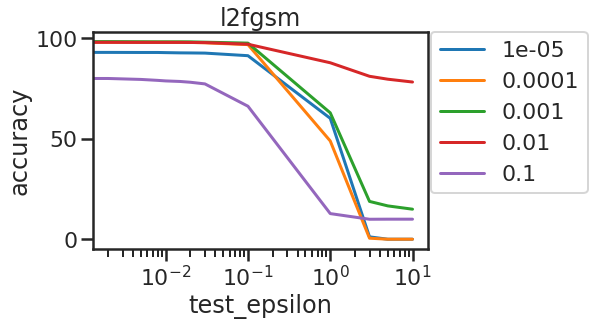

In [228]:
# Display learning rate impact
epsilon = 0.1
backbone = 'MLP'
robust_training = False

if robust_training:
    ids = list(set(parameters["backbone"][backbone]) & set(parameters["epsilon"][epsilon]) &
               set(parameters["robust_training"][robust_training]))
else:
    ids = list(set(parameters["backbone"][backbone]) &
            set(parameters["robust_training"][robust_training]))

print(ids)
list_entries = []
for id in ids:
    entry = {"learning_rate": experiment_list[id]['initial_learning_rate'],
            "backbone": experiment_list[id]['backbone'],
            "robust_training": experiment_list[id]['robust_training'],
            "epsilon": experiment_list[id]['epsilon']}
 
    for dataset in ["val", "test"]:
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)
            
            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                
df = pd.DataFrame.from_dict(list_entries) 

plt.figure()
sns.lineplot(x="test_epsilon", y="accuracy",
             hue="learning_rate",  palette="tab10",
             data=df[df.dataset=='test'][df.attack=='linfpgd']).set_title("linfpgd")
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)


ax = plt.figure()
sns.lineplot(x="test_epsilon", y="accuracy",
             hue="learning_rate",  palette="tab10",
             data=df[df.dataset=='test'][df.attack=='l2fgsm']).set_title("l2fgsm")
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


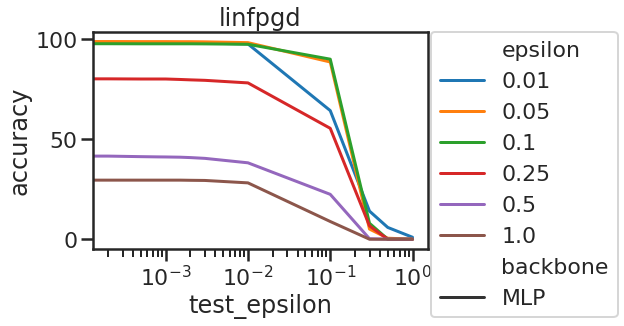

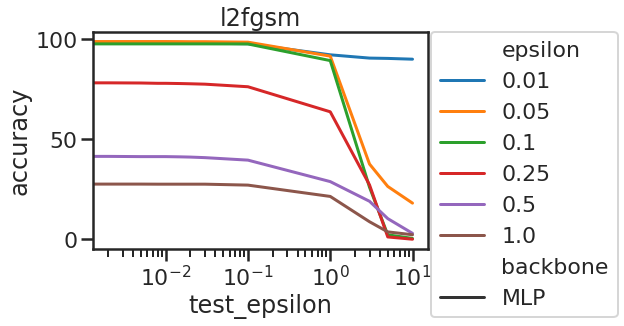

In [229]:
# Display epsilon
backbones = ['MLP', 'CNN']
robust_training = True
list_entries = []
for backbone in backbones:
    for epsilon in list(parameters["epsilon"].keys()):

        ids = list(set(parameters["backbone"][backbone]) & set(parameters["epsilon"][epsilon]) &
                       set(parameters["robust_training"][robust_training]))

        # Cross-validation among learning rates:
        best_acc = 0.0
        best_id = -1
        for id in ids:
            acc = 0.0
            for attack in name_attacks:
                with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + 
                    attack + '.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                
                ave_acc = 0.0
                for test_epsilon in tmp.keys():
                    ave_acc += tmp[test_epsilon]
                ave_acc = ave_acc / len(tmp.keys())
                acc += ave_acc
            acc = acc / 2
            if acc>best_acc:
                best_id = id
                best_acc = acc

        entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                "backbone": experiment_list[best_id]['backbone'],
                "robust_training": experiment_list[best_id]['robust_training'],
                "epsilon": experiment_list[best_id]['epsilon']}

        dataset = "test"
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)

            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                
df = pd.DataFrame.from_dict(list_entries) 

plt.figure()
sns.lineplot(x="test_epsilon", y="accuracy",
             hue="epsilon",  style='backbone', palette="tab10",
             data=df[df.backbone=='MLP'][df.attack=='linfpgd']).set_title("linfpgd")
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

plt.figure()
sns.lineplot(x="test_epsilon", y="accuracy",
             hue="epsilon",  style='backbone', palette="tab10",
             data=df[df.backbone=='MLP'][df.attack=='l2fgsm']).set_title("l2fgsm")
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

6
61
44
{0.0: 0.989453125, 0.002: 0.989453125, 0.005: 0.989453125, 0.008: 0.989453125, 0.01: 0.989453125, 0.015: 0.9890625, 0.02: 0.9890625, 0.03: 0.9890625, 0.1: 0.987890625, 1.0: 0.94140625, 3.0: 0.50390625, 5.0: 0.18046875, 10.0: 0.038671875}
66
{0.0: 0.99296875, 0.002: 0.99296875, 0.005: 0.992578125, 0.008: 0.9921875, 0.01: 0.9921875, 0.015: 0.991796875, 0.02: 0.990625, 0.03: 0.990234375, 0.1: 0.98515625, 1.0: 0.955859375, 3.0: 0.945703125, 5.0: 0.94453125, 10.0: 0.936328125}


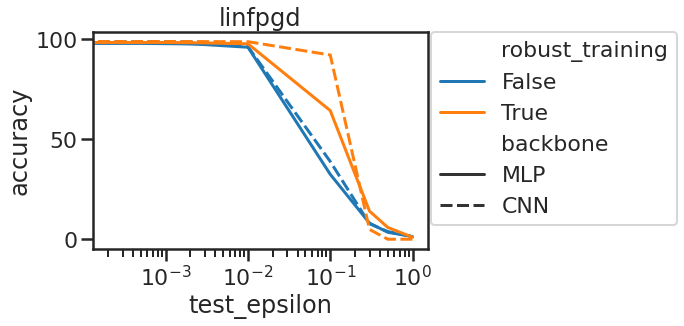

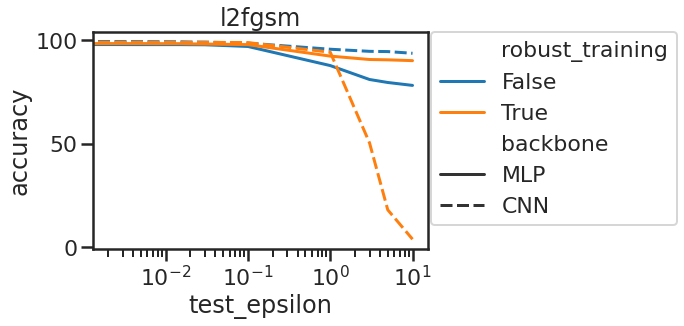

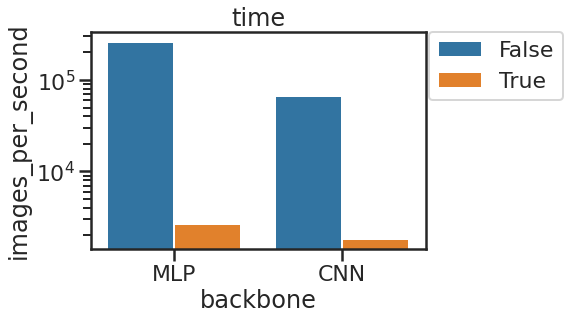

In [231]:
# Display best
backbones = ['MLP', 'CNN']
robust_trainings = [True, False]

list_entries = []
for backbone in backbones:
    for robust_training in robust_trainings:

        ids = list(set(parameters["backbone"][backbone]) & set(parameters["robust_training"][robust_training]))

        # Cross-validation among learning rates:
        best_acc = 0.0
        best_id = -1
        for id in ids:
            acc = 0.0
            for attack in name_attacks:
                with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + 
                    attack + '.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                
                ave_acc = 0.0
                for test_epsilon in tmp.keys():
                    ave_acc += tmp[test_epsilon]
                ave_acc = ave_acc / len(tmp.keys())
                acc += ave_acc
            acc = acc / 2
            if acc>best_acc:
                best_id = id
                best_acc = acc

        entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                "backbone": experiment_list[best_id]['backbone'],
                "robust_training": experiment_list[best_id]['robust_training'],
                "epsilon": experiment_list[best_id]['epsilon']}

        dataset = "test"
        print(best_id)
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)
            if attack == 'l2fgsm' and backbone == 'CNN':
                print(tmp)
            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                
            with open(results_dir + experiment_list[best_id]['model_name'] + 
                      '/results/training_time.pkl', 'rb') as f:
                tmp = pickle.load(f)
            entry["images_per_second"] = np.mean(tmp) 
            entry["std_images_per_second"] = np.std(tmp) 
                
df = pd.DataFrame.from_dict(list_entries) 

plt.figure()
sns.lineplot(x="test_epsilon", y="accuracy",
             hue="robust_training",  style='backbone', palette="tab10",
             data=df[df.attack=='linfpgd']).set_title("linfpgd")
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

plt.figure()
sns.lineplot(x="test_epsilon", y="accuracy",
             hue="robust_training",  style='backbone', palette="tab10",
             data=df[df.attack=='l2fgsm']).set_title("l2fgsm")
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

plt.figure()
sns.barplot(x="backbone", y="images_per_second",
             hue="robust_training", palette="tab10",
             data=df).set_title("time")
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

In [222]:
df[df.backbone=="CNN"][df.attack=="l2fgsm"][df.test_epsilon>=1.0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,learning_rate,backbone,robust_training,epsilon,dataset,attack,test_epsilon,accuracy,images_per_second,std_images_per_second
74,0.001,CNN,True,0.1,test,l2fgsm,1.0,94.140625,1802.553114,16.028022
75,0.001,CNN,True,0.1,test,l2fgsm,3.0,50.390625,1802.553114,16.028022
76,0.001,CNN,True,0.1,test,l2fgsm,5.0,18.046875,1802.553114,16.028022
77,0.001,CNN,True,0.1,test,l2fgsm,10.0,3.867188,1802.553114,16.028022
100,0.010,CNN,False,1.0,test,l2fgsm,1.0,95.585938,66000.469272,1429.715905
101,0.010,CNN,False,1.0,test,l2fgsm,3.0,94.570312,66000.469272,1429.715905
102,0.010,CNN,False,1.0,test,l2fgsm,5.0,94.453125,66000.469272,1429.715905
103,0.010,CNN,False,1.0,test,l2fgsm,10.0,93.632812,66000.469272,1429.715905
